## **Data Loading**

In [ ]:
import gdown
drive_link = 'https://drive.google.com/file/d/1-1vVh7moyW_eBKl_GL-TDILl-LnqMYk0/view?usp=sharing'

file_id = drive_link.split('/d/')[1].split('/')[0]
gdown_url = f'https://drive.google.com/uc?id={file_id}'

output_file = 'sepsis_data.csv'
gdown.download(gdown_url, output_file, quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1-1vVh7moyW_eBKl_GL-TDILl-LnqMYk0
From (redirected): https://drive.google.com/uc?id=1-1vVh7moyW_eBKl_GL-TDILl-LnqMYk0&confirm=t&uuid=d7ff50c3-a6e0-44d0-9eb7-aa26a6afc29e
To: /kaggle/working/sepsis_data.csv
100%|██████████| 779M/779M [00:08<00:00, 91.5MB/s] 


'sepsis_data.csv'

## **Imports**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd
from tqdm import tqdm

# Scikit-learn modules
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.tree import plot_tree


# TensorFlow / Keras modules
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, LSTM, GRU, Dense, Dropout, Bidirectional,
    TimeDistributed, BatchNormalization, GlobalAveragePooling1D
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from IPython.display import display, clear_output
import ipywidgets as widgets


np.random.seed(42)
tf.random.set_seed(42)
warnings.filterwarnings('ignore')


2025-05-03 05:29:04.953488: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746250145.166931      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746250145.224759      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
!pip install --upgrade scikit-learn
!pip install --upgrade imbalanced-learn


# **============================================================================================**

## **Sampling & Model & Evaluation Functions**

In [ ]:

def load_and_preprocess_data(filepath):
    """Load and clean data with memory-efficient datatypes"""
    print("\n[STEP 1] Loading data...")
    # Read column names first to set datatypes efficiently
    dtype_dict = {col: 'float32' for col in pd.read_csv(filepath, nrows=1).columns
                if col not in ['Patient_ID', 'SepsisLabel', 'ICULOS']}
    dtype_dict.update({'Patient_ID': 'str', 'SepsisLabel': 'int8', 'ICULOS': 'int16'})

    # Use chunks for more memory-efficient loading of large files
    df = pd.read_csv(filepath, dtype=dtype_dict)
    df = df.sort_values(['Patient_ID', 'ICULOS'])

    # Handle missing values - simplified approach
    cols_to_impute = [col for col in df.columns if col not in ['Patient_ID', 'SepsisLabel', 'ICULOS']]

    # First forward fill within patient groups
    df[cols_to_impute] = df.groupby('Patient_ID')[cols_to_impute].transform(lambda x: x.ffill())

    # Then backward fill remaining values
    df[cols_to_impute] = df.groupby('Patient_ID')[cols_to_impute].transform(lambda x: x.bfill())

    # Finally fill any remaining NaNs with 0
    df[cols_to_impute] = df[cols_to_impute].fillna(0)

    print("Initial class distribution:")
    print(df['SepsisLabel'].value_counts())
    return df

# Create patient sequences
def create_patient_sequences(df, sequence_length=10):
    """Create sequences with memory-efficient implementation"""
    print(f"\n[STEP 2] Creating sequences (length={sequence_length})...")
    # Pre-allocate lists for efficiency
    sequences = []
    labels = []

    # Select only needed columns for feature extraction
    feature_cols = [col for col in df.columns if col not in ['Patient_ID', 'SepsisLabel', 'ICULOS']]

    # Process patients one by one to manage memory
    for pid, group in df.groupby('Patient_ID'):
        # Extract features and labels
        features = group[feature_cols].values
        sepsis_labels = group['SepsisLabel'].values

        # Handle sequences shorter than desired length
        if len(features) < sequence_length:
            # Pad with zeros at the beginning (representing historical data we don't have)
            pad_len = sequence_length - len(features)
            features = np.vstack([np.zeros((pad_len, features.shape[1])), features])
            sepsis_labels = np.concatenate([np.zeros(pad_len), sepsis_labels])

        # Create sliding windows - optimized to avoid unnecessary operations
        for i in range(0, len(features) - sequence_length + 1, 1):  # Step size of 1
            seq = features[i:i+sequence_length]
            # Label as 1 if sepsis occurs within the sequence window
            label = 1 if np.any(sepsis_labels[i:i+sequence_length] > 0) else 0
            sequences.append(seq)
            labels.append(label)

    # Convert to numpy arrays for TensorFlow compatibility
    X = np.array(sequences, dtype=np.float32)  # Explicit dtype
    y = np.array(labels, dtype=np.int8)  # Explicit dtype

    print(f"Created {len(X)} sequences")
    print(f"Class 0: {np.sum(y == 0)}, Class 1: {np.sum(y == 1)}")
    return X, y, feature_cols

#  Decision Tree based undersampling
def decision_tree_undersampling(X, y, target_samples=35000):
    print(f"\nUndersampling majority class to {target_samples} samples...")

    # Get indices of majority class
    majority_indices = np.where(y == 0)[0]

    # If we already have fewer samples than target, return as is
    if len(majority_indices) <= target_samples:
        return X, y

    # Randomly select subset for efficiency
    np.random.shuffle(majority_indices)
    subset_indices = majority_indices[:min(50000, len(majority_indices))]  # Limit for efficiency

    # Flatten the time steps for feature importance calculation
    X_flattened = X[subset_indices].reshape(-1, X.shape[-1])
    y_flattened = np.repeat(y[subset_indices], X.shape[1])

    # Train decision tree to find most important samples
    dt = DecisionTreeClassifier(max_depth=5, random_state=42)
    dt.fit(X_flattened, y_flattened)

    # Get feature importances for each sample
    sample_importances = []
    for idx in subset_indices:
        # Calculate average feature importance across all time steps
        importance = np.mean([dt.feature_importances_ for _ in range(X.shape[1])], axis=0)
        sample_importances.append(np.sum(importance))

    # Select samples with highest importance scores
    selected_indices = np.argsort(sample_importances)[-target_samples:]

    # Combine with minority class
    minority_indices = np.where(y == 1)[0]
    final_indices = np.concatenate([subset_indices[selected_indices], minority_indices])

    return X[final_indices], y[final_indices]

#  Decision Tree based upsampling
def decision_tree_upsampling(X, y, target_samples=27000):
    print(f"\nUpsampling minority class to {target_samples} samples...")

    # Get indices of minority class
    minority_indices = np.where(y == 1)[0]

    # If we already have more samples than target, return as is
    if len(minority_indices) >= target_samples:
        return X, y

    # Calculate how many samples we need to generate
    num_to_generate = target_samples - len(minority_indices)

    # Flatten the time steps for feature importance calculation
    X_flattened = X.reshape(-1, X.shape[-1])
    y_flattened = np.repeat(y, X.shape[1])

    # Train decision tree to understand feature relationships
    dt = DecisionTreeClassifier(max_depth=5, random_state=42)
    dt.fit(X_flattened, y_flattened)

    # Generate synthetic samples based on feature distributions
    synthetic_samples = []
    for _ in range(num_to_generate):
        # Randomly select a minority sample to base new sample on
        base_sample = X[np.random.choice(minority_indices)]

        # Create synthetic sample by perturbing features based on importance
        synthetic_sample = base_sample.copy()
        for t in range(X.shape[1]):  # For each time step
            for f in range(X.shape[2]):  # For each feature
                if dt.feature_importances_[f] > 0.01:  # Only modify important features
                    # Add noise proportional to feature importance
                    noise = np.random.normal(0, dt.feature_importances_[f] * 0.1)
                    synthetic_sample[t, f] += noise

        synthetic_samples.append(synthetic_sample)

    # Convert list of synthetic samples to numpy array with same shape as X
    synthetic_samples = np.array(synthetic_samples)

    # Combine real and synthetic samples
    X_upsampled = np.concatenate([X, synthetic_samples])
    y_upsampled = np.concatenate([y, np.ones(num_to_generate, dtype=np.int8)])

    return X_upsampled, y_upsampled

# Prepare balanced dataset
def prepare_balanced_dataset(X, y, target_class0=35000, target_class1=27000):

    print("\n[STEP 3] Preparing balanced dataset...")

    # First, undersample class 0 to exact target
    X_undersampled, y_undersampled = decision_tree_undersampling(X, y, target_samples=target_class0)

    # Then, upsample class 1 to exact target
    X_balanced, y_balanced = decision_tree_upsampling(X_undersampled, y_undersampled, target_samples=target_class1)

    # Shuffle the dataset
    indices = np.arange(len(y_balanced))
    np.random.shuffle(indices)
    X_balanced = X_balanced[indices]
    y_balanced = y_balanced[indices]

    print(f"Final balanced dataset - Class 0: {np.sum(y_balanced == 0)}, Class 1: {np.sum(y_balanced == 1)}")
    return X_balanced, y_balanced
# Train-test split
def custom_train_test_split_with_balancing(X, y, train_class0=35000, train_class1=27000):

    print("\n[STEP 4] Custom train-test split with balanced classes...")

    # Get indices for each class
    indices_class0 = np.where(y == 0)[0]
    indices_class1 = np.where(y == 1)[0]

    print(f"Total samples - Class 0: {len(indices_class0)}, Class 1: {len(indices_class1)}")

    # Make sure we don't request more samples than available
    train_class0 = min(train_class0, len(indices_class0))
    train_class1 = min(train_class1, len(indices_class1))

    # Randomly select indices for training set for each class
    np.random.shuffle(indices_class0)
    np.random.shuffle(indices_class1)

    train_indices_class0 = indices_class0[:train_class0]
    train_indices_class1 = indices_class1[:train_class1]

    # Remaining indices go to test set
    test_indices_class0 = indices_class0[train_class0:]
    test_indices_class1 = indices_class1[train_class1:]

    # Combine indices
    train_indices = np.concatenate([train_indices_class0, train_indices_class1])
    test_indices = np.concatenate([test_indices_class0, test_indices_class1])

    np.random.shuffle(train_indices)

    # Create the training and test sets
    X_train = X[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    y_test = y[test_indices]

    print(f"Training set - Class 0: {np.sum(y_train == 0)}, Class 1: {np.sum(y_train == 1)}")
    print(f"Test set - Class 0: {np.sum(y_test == 0)}, Class 1: {np.sum(y_test == 1)}")

    return X_train, X_test, y_train, y_test
from tensorflow.keras.layers import Input, Conv1D, Concatenate, GlobalAveragePooling1D, Dense, Add, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

from tensorflow.keras.layers import Conv1D, Dropout, Concatenate

def inception_module(input_tensor, filters=32, dropout_rate=0.5):
    branch10 = Conv1D(filters, 10, padding='same', activation='relu')(input_tensor)
    branch10 = Dropout(dropout_rate)(branch10)  # Dropout added

    branch20 = Conv1D(filters, 20, padding='same', activation='relu')(input_tensor)
    branch20 = Dropout(dropout_rate)(branch20)  # Dropout added

    branch40 = Conv1D(filters, 40, padding='same', activation='relu')(input_tensor)
    branch40 = Dropout(dropout_rate)(branch40)  # Dropout added

    return Concatenate(axis=-1)([branch10, branch20, branch40])


def build_inception_time(input_shape, filters=32, depth=3):
    """
    Simplified InceptionTime model with:
    - Three parallel conv filters (10, 20, 40 time steps)
    - No residual connections
    - Single dense output layer
    """
    inputs = Input(shape=input_shape)
    x = inputs

    # Stack of Inception modules
    for _ in range(depth):
        x = inception_module(x, filters)

    # Global pooling and output
    x = GlobalAveragePooling1D()(x)
    outputs = Dense(1, activation='sigmoid')(x)  # For binary classification

    model = Model(inputs, outputs)
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )

    return model

# Example usage
model = build_inception_time(input_shape=(X_train.shape[1], X_train.shape[2]))
model.summary()

def evaluate_model(model, X, y, set_name="Test"):
    """Evaluate model performance"""
    print(f"\n{set_name} Set Evaluation:")

    y_prob = model.predict(X)
    y_pred = (y_prob > 0.5).astype(int)


    print(classification_report(y, y_pred))

    auc = roc_auc_score(y, y_prob)
    print(f"ROC AUC: {auc:.4f}")

    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=['No Sepsis', 'Sepsis'],
               yticklabels=['No Sepsis', 'Sepsis'])
    plt.title(f'Confusion Matrix - {set_name} Set')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10            │ (None, 10, 51)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_153 (Conv1D)       │ (None, 10, 32)         │         16,352 │ input_layer_10[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_154 (Conv1D)       │ (None, 10, 32)         │         32,672 │ input_layer_10[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_155 (Conv1D)       │ (None, 10, 32)         │         65,312 │ input_layer_10[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_22 (Dropout)      │ (None, 10, 32)         │              0 │ conv1d_153[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_23 (Dropout)      │ (None, 10, 32)         │              0 │ conv1d_154[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_24 (Dropout)      │ (None, 10, 32)         │              0 │ conv1d_155[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_37            │ (None, 10, 96)         │              0 │ dropout_22[0][0],      │
│ (Concatenate)             │                        │                │ dropout_23[0][0],      │
│                           │                        │                │ dropout_24[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_156 (Conv1D)       │ (None, 10, 32)         │         30,752 │ concatenate_37[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_157 (Conv1D)       │ (None, 10, 32)         │         61,472 │ concatenate_37[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_158 (Conv1D)       │ (None, 10, 32)         │        122,912 │ concatenate_37[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_25 (Dropout)      │ (None, 10, 32)         │              0 │ conv1d_156[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_26 (Dropout)      │ (None, 10, 32)         │              0 │ conv1d_157[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_27 (Dropout)      │ (None, 10, 32)         │              0 │ conv1d_158[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_38            │ (None, 10, 96)         │              0 │ dropout_25[0][0],      │
│ (Concatenate)             │                        │                │ dropout_26[0][0],      │
│                           │                        │                │ dropout_27[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_159 (Conv1D)       │ (None, 10, 32)         │         30,752 │ concatenate_38[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_160 (Conv1D)       │ (None, 10, 32)         │         61,472 │ concatenate_38[0][0]   │
├──────────────────────

 Total params: 544,705 (2.08 MB)

 Trainable params: 544,705 (2.08 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
 filepath = "/kaggle/working/sepsis_data.csv"
df = load_and_preprocess_data(filepath)


[STEP 1] Loading data...
Initial class distribution:
SepsisLabel
0    1510640
1      26715
Name: count, dtype: int64


In [ ]:
df.columns

Index(['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'BaseExcess',
       'FiO2', 'pH', 'PaCO2', 'BUN', 'Calcium', 'Creatinine', 'Glucose',
       'Magnesium', 'Potassium', 'Hct', 'Hgb', 'WBC', 'Platelets', 'Age',
       'Gender', 'HospAdmTime', 'ICULOS', 'SepsisLabel', 'Patient_ID',
       'EtCO2_measured', 'HCO3_measured', 'SaO2_measured', 'AST_measured',
       'Alkalinephos_measured', 'Chloride_measured',
       'Bilirubin_direct_measured', 'Lactate_measured', 'Phosphate_measured',
       'Bilirubin_total_measured', 'TroponinI_measured', 'PTT_measured',
       'Fibrinogen_measured', 'Temp_observed', 'BaseExcess_observed',
       'FiO2_observed', 'pH_observed', 'PaCO2_observed', 'BUN_observed',
       'Calcium_observed', 'Creatinine_observed', 'Glucose_observed',
       'Magnesium_observed', 'Potassium_observed', 'Hct_observed',
       'Hgb_observed', 'WBC_observed', 'Platelets_observed', 'Unit1_observed',
       'Unit2_observed', 'DBP_measured'],
      dtype='object')

In [ ]:
cols_to_drop = ['Unit2_observed', 'Unit1_observed', 'HospAdmTime','Age']
existing_cols = [col for col in cols_to_drop if col in df.columns]

if existing_cols:
    df = df.drop(columns=existing_cols)
else:
    print("None of these columns exist in the DataFrame")

In [ ]:

X, y, feature_cols = create_patient_sequences(df, sequence_length=10)


[STEP 2] Creating sequences (length=10)...
Created 1179170 sequences
Class 0: 1157517, Class 1: 21653


In [ ]:
X_balanced, y_balanced = prepare_balanced_dataset(X, y, target_class0=50022, target_class1=35000)
X_train, X_test, y_train, y_test = custom_train_test_split_with_balancing(X_balanced, y_balanced, train_class0=35000, train_class1=27000)


[STEP 3] Preparing balanced dataset...

Undersampling majority class to 50022 samples...

Upsampling minority class to 35000 samples...
Final balanced dataset - Class 0: 50000, Class 1: 35000

[STEP 4] Custom train-test split with balanced classes...
Total samples - Class 0: 50000, Class 1: 35000
Training set - Class 0: 35000, Class 1: 27000
Test set - Class 0: 15000, Class 1: 8000


In [ ]:

    # # Step 5: Feature scaling
    # print("\n[STEP 5] Scaling features...")
    # scaler = StandardScaler()
    # # Reshape for scaling and back
    # X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
    # X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)


[STEP 5] Scaling features...


## **Training**

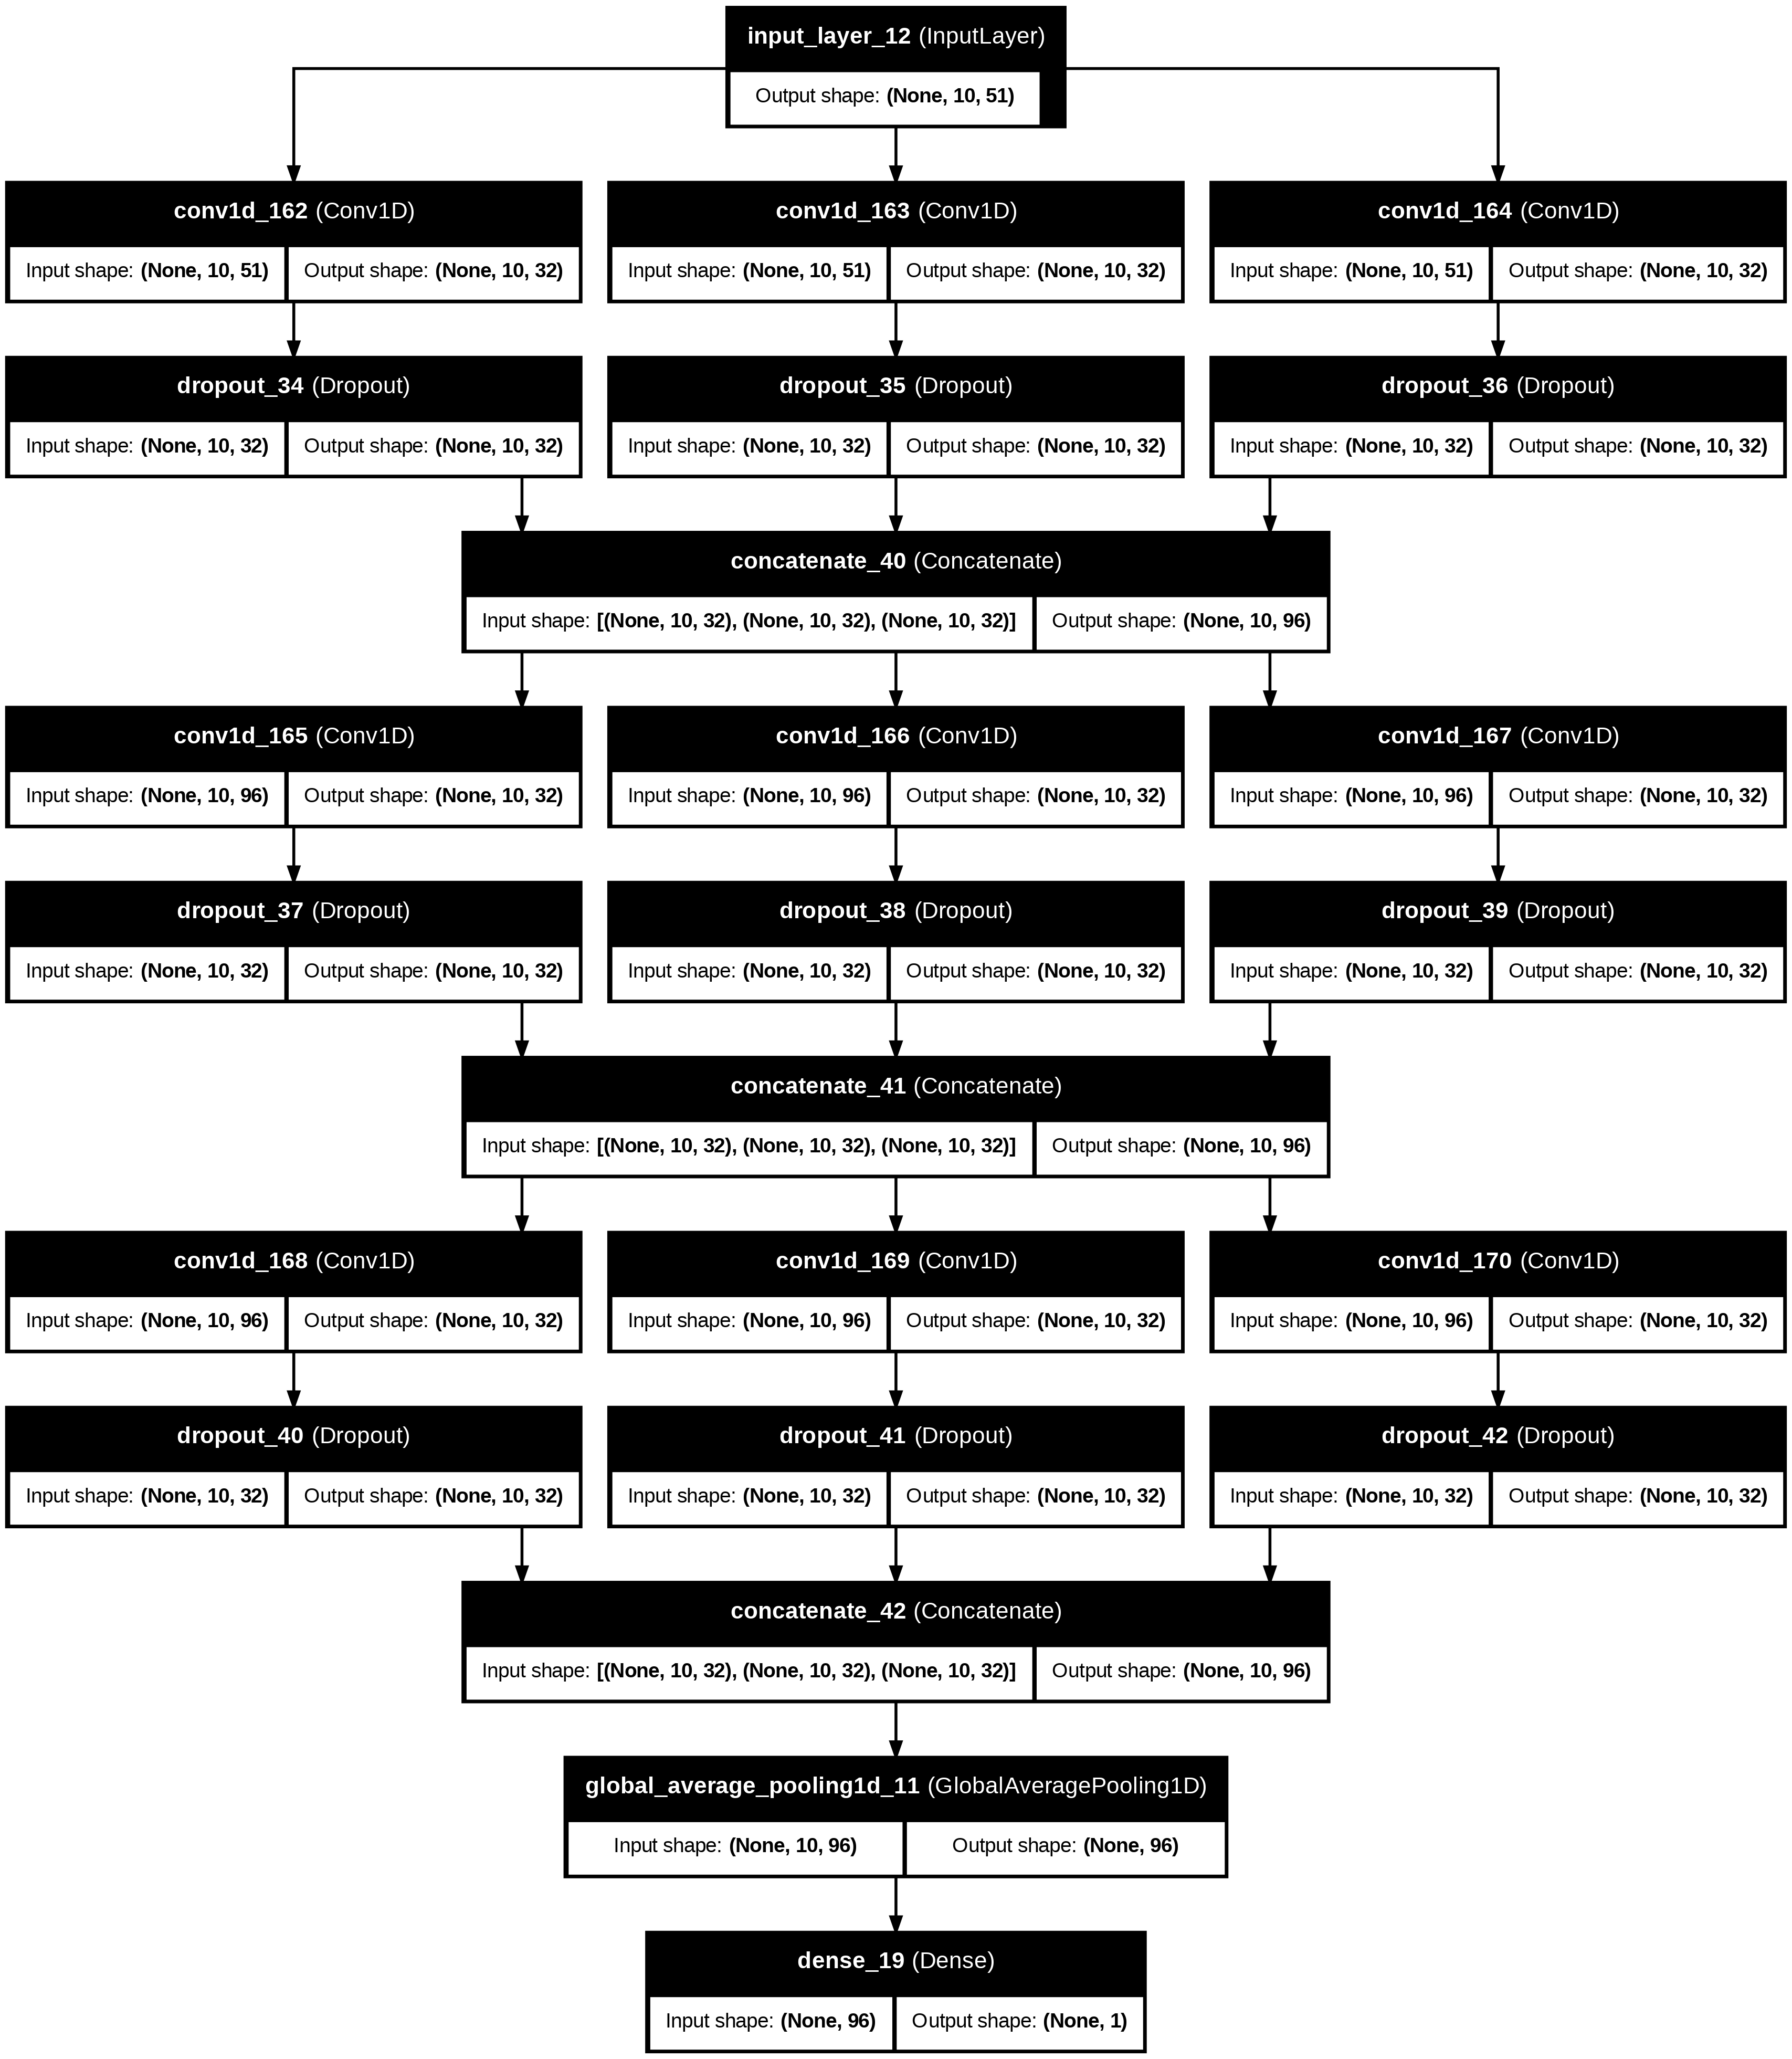

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)


In [ ]:
print("\n[STEP 6] Building model...")
model = build_inception_time((X_train.shape[1], X_train.shape[2]))
model.summary()


print("\n[STEP 7] Training model...")
callbacks = [
        EarlyStopping(monitor='val_auc', patience=5, mode='max', restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
    ]

history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=20,
        batch_size=64,
        callbacks=callbacks,
        class_weight={0:1, 1: 1.5},
        verbose=1
    )


[STEP 6] Building model...


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12            │ (None, 10, 51)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_162 (Conv1D)       │ (None, 10, 32)         │         16,352 │ input_layer_12[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_163 (Conv1D)       │ (None, 10, 32)         │         32,672 │ input_layer_12[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_164 (Conv1D)       │ (None, 10, 32)         │         65,312 │ input_layer_12[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_34 (Dropout)      │ (None, 10, 32)         │              0 │ conv1d_162[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_35 (Dropout)      │ (None, 10, 32)         │              0 │ conv1d_163[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_36 (Dropout)      │ (None, 10, 32)         │              0 │ conv1d_164[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_40            │ (None, 10, 96)         │              0 │ dropout_34[0][0],      │
│ (Concatenate)             │                        │                │ dropout_35[0][0],      │
│                           │                        │                │ dropout_36[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_165 (Conv1D)       │ (None, 10, 32)         │         30,752 │ concatenate_40[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_166 (Conv1D)       │ (None, 10, 32)         │         61,472 │ concatenate_40[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_167 (Conv1D)       │ (None, 10, 32)         │        122,912 │ concatenate_40[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_37 (Dropout)      │ (None, 10, 32)         │              0 │ conv1d_165[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_38 (Dropout)      │ (None, 10, 32)         │              0 │ conv1d_166[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_39 (Dropout)      │ (None, 10, 32)         │              0 │ conv1d_167[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_41            │ (None, 10, 96)         │              0 │ dropout_37[0][0],      │
│ (Concatenate)             │                        │                │ dropout_38[0][0],      │
│                           │                        │                │ dropout_39[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_168 (Conv1D)       │ (None, 10, 32)         │         30,752 │ concatenate_41[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_169 (Conv1D)       │ (None, 10, 32)         │         61,472 │ concatenate_41[0][0]   │
├──────────────────────

 Total params: 544,705 (2.08 MB)

 Trainable params: 544,705 (2.08 MB)

 Non-trainable params: 0 (0.00 B)


[STEP 7] Training model...
Epoch 1/20
969/969 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - accuracy: 0.6633 - auc: 0.7430 - loss: 0.7278 - val_accuracy: 0.7084 - val_auc: 0.8077 - val_loss: 0.5681 - learning_rate: 0.0010
Epoch 2/20
969/969 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7188 - auc: 0.8058 - loss: 0.6504 - val_accuracy: 0.7286 - val_auc: 0.8264 - val_loss: 0.5384 - learning_rate: 0.0010
Epoch 3/20
969/969 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7402 - auc: 0.8281 - loss: 0.6127 - val_accuracy: 0.7320 - val_auc: 0.8472 - val_loss: 0.5099 - learning_rate: 0.0010
Epoch 4/20
969/969 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7608 - auc: 0.8492 - loss: 0.5741 - val_accuracy: 0.7582 - val_auc: 0.8612 - val_loss: 0.4866 - learning_rate: 0.0010
Epoch 5/20
969/969 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7728 - auc: 0.8645 - loss: 0.5451 - val_accuracy: 0.7686 - val_auc: 0.8718 - val_loss: 0.4614 - learning_rate: 0.0010
Epoch 6/20
969/969 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/ste

## **Evaluation**


[STEP 8] Plotting training metrics...


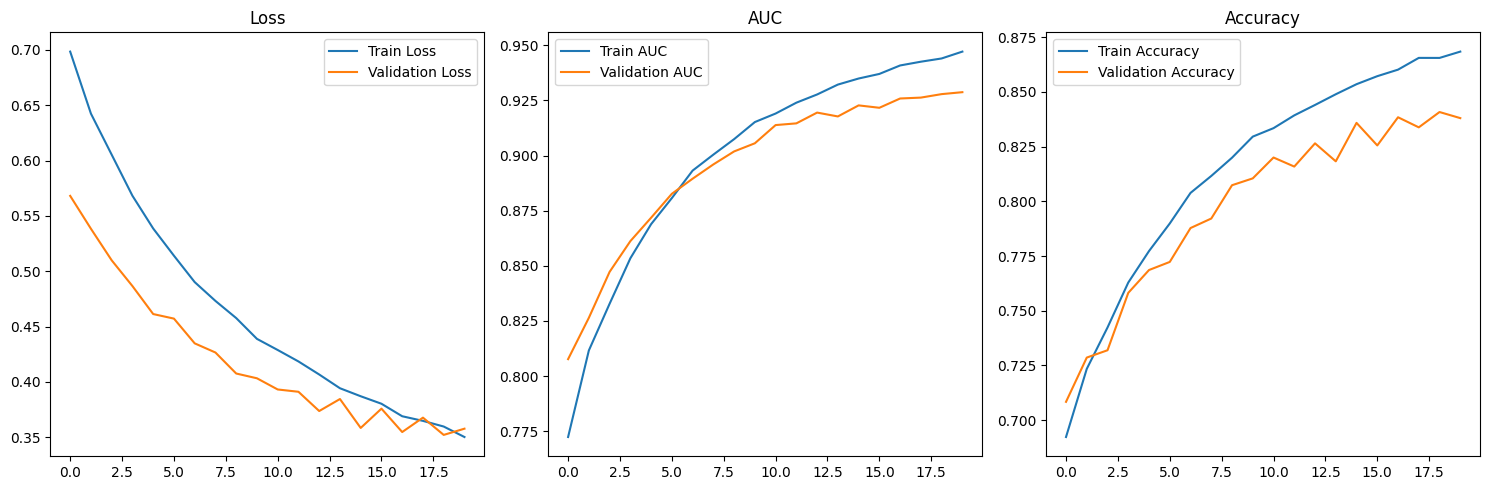


[STEP 9] Evaluating model...

Train Set Evaluation:
1938/1938 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
              precision    recall  f1-score   support

           0       0.98      0.88      0.93     35000
           1       0.86      0.98      0.92     27000

    accuracy                           0.92     62000
   macro avg       0.92      0.93      0.92     62000
weighted avg       0.93      0.92      0.92     62000

ROC AUC: 0.9852


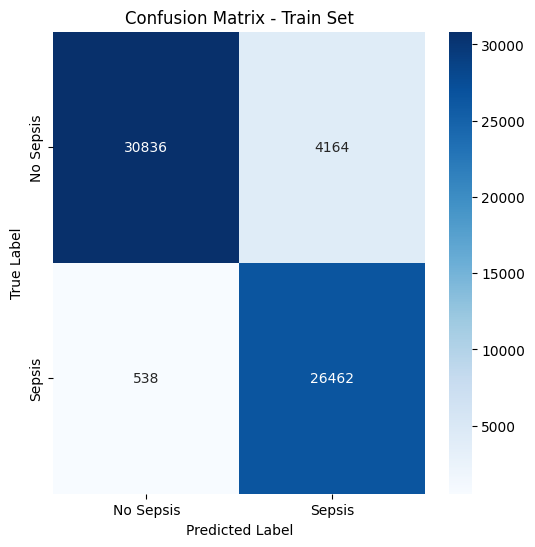


Test Set Evaluation:
719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

           0       0.96      0.79      0.86     15000
           1       0.70      0.93      0.80      8000

    accuracy                           0.84     23000
   macro avg       0.83      0.86      0.83     23000
weighted avg       0.87      0.84      0.84     23000

ROC AUC: 0.9288


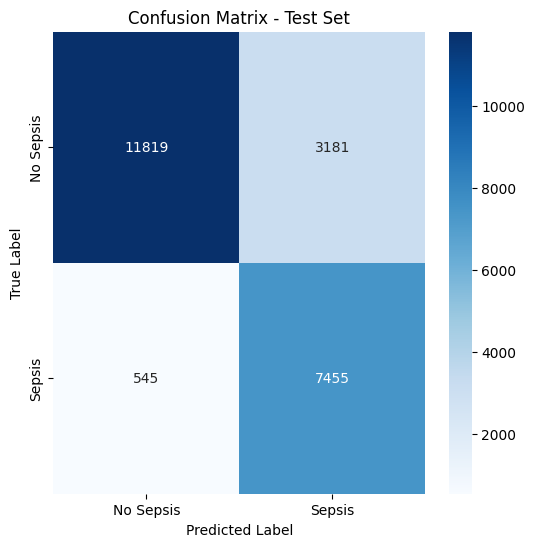

In [ ]:
 print("\n[STEP 8] Plotting training metrics...")
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.title('AUC')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

    # Step 9: Evaluate model
print("\n[STEP 9] Evaluating model...")
evaluate_model(model, X_train, y_train, "Train")
evaluate_model(model, X_test, y_test, "Test")

## **Explaination**

### **Glopal Surrogate Model Agnostic**

In [ ]:
train_predictions = model.predict(X_train)
train_predictions_class = (train_predictions > 0.5).astype(int)
surrogate_model = DecisionTreeClassifier(max_depth=5)
surrogate_model.fit(X_train.reshape(X_train.shape[0], -1), train_predictions_class)


1938/1938 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


DecisionTreeClassifier(max_depth=5)

In [ ]:
X_train.shape

(62000, 10, 55)

In [ ]:
df['BaseExcess_observed']

317787     0.0
317788     0.0
317789     0.0
317790     1.0
317791     0.0
          ... 
1334160    0.0
1334161    0.0
1334162    0.0
1334163    0.0
1334164    0.0
Name: BaseExcess_observed, Length: 1537355, dtype: float32

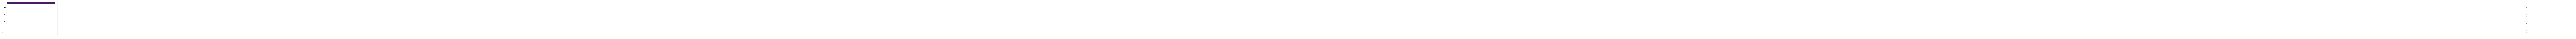

In [ ]:

feature_importance = surrogate_model.feature_importances_
try:
    if 'df' in locals() or 'df' in globals():
        feature_cols = [col for col in df.columns if col not in ['Patient_ID', 'SepsisLabel']]
    elif 'feature_cols' in locals() or 'feature_cols' in globals():
        feature_cols = feature_cols
    else:
        feature_cols = [f'Feature_{i}' for i in range(len(feature_importance))]

    # Fix mismatch
    min_len = min(len(feature_cols), len(feature_importance))
    feature_cols = feature_cols[:min_len]
    feature_importance = feature_importance[:min_len]

except Exception as e:
    print(f"Using fallback feature names due to error: {e}")
    feature_cols = [f'F{i}' for i in range(len(feature_importance))]

importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

top_n = min(15, len(importance_df))

plt.figure(figsize=(12, 8))
ax = sns.barplot(x='Importance', y='Feature',
                 data=importance_df.head(top_n),
                 palette='viridis', saturation=0.9)

for i, (_, row) in enumerate(importance_df.head(top_n).iterrows()):
    ax.text(row['Importance'] + 0.005, i, f"{row['Importance']:.3f}",
            va='center', fontsize=10)

plt.title(f'Top {top_n} Feature Importances', fontsize=16, weight='bold')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


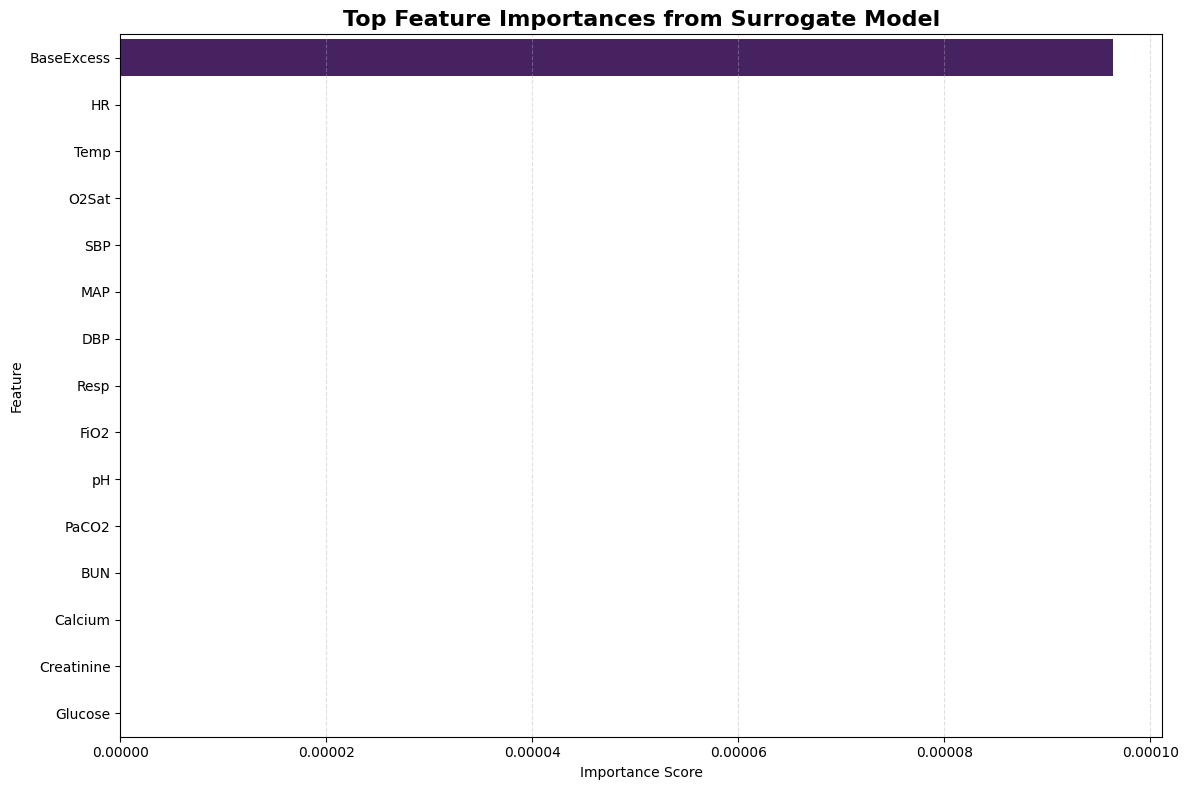

In [ ]:
feature_importance = surrogate_model.feature_importances_
min_len = min(len(feature_cols), len(feature_importance))
feature_cols_matched = feature_cols[:min_len]
feature_importance = feature_importance[:min_len]

importance_df = pd.DataFrame({
    "Feature": feature_cols_matched,
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)

top_n = min(15, len(importance_df))
plt.figure(figsize=(12, 8))
sns.barplot(x="Importance", y="Feature", data=importance_df.head(top_n), palette='viridis')

plt.title("Top Feature Importances from Surrogate Model", fontsize=16, weight='bold')
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


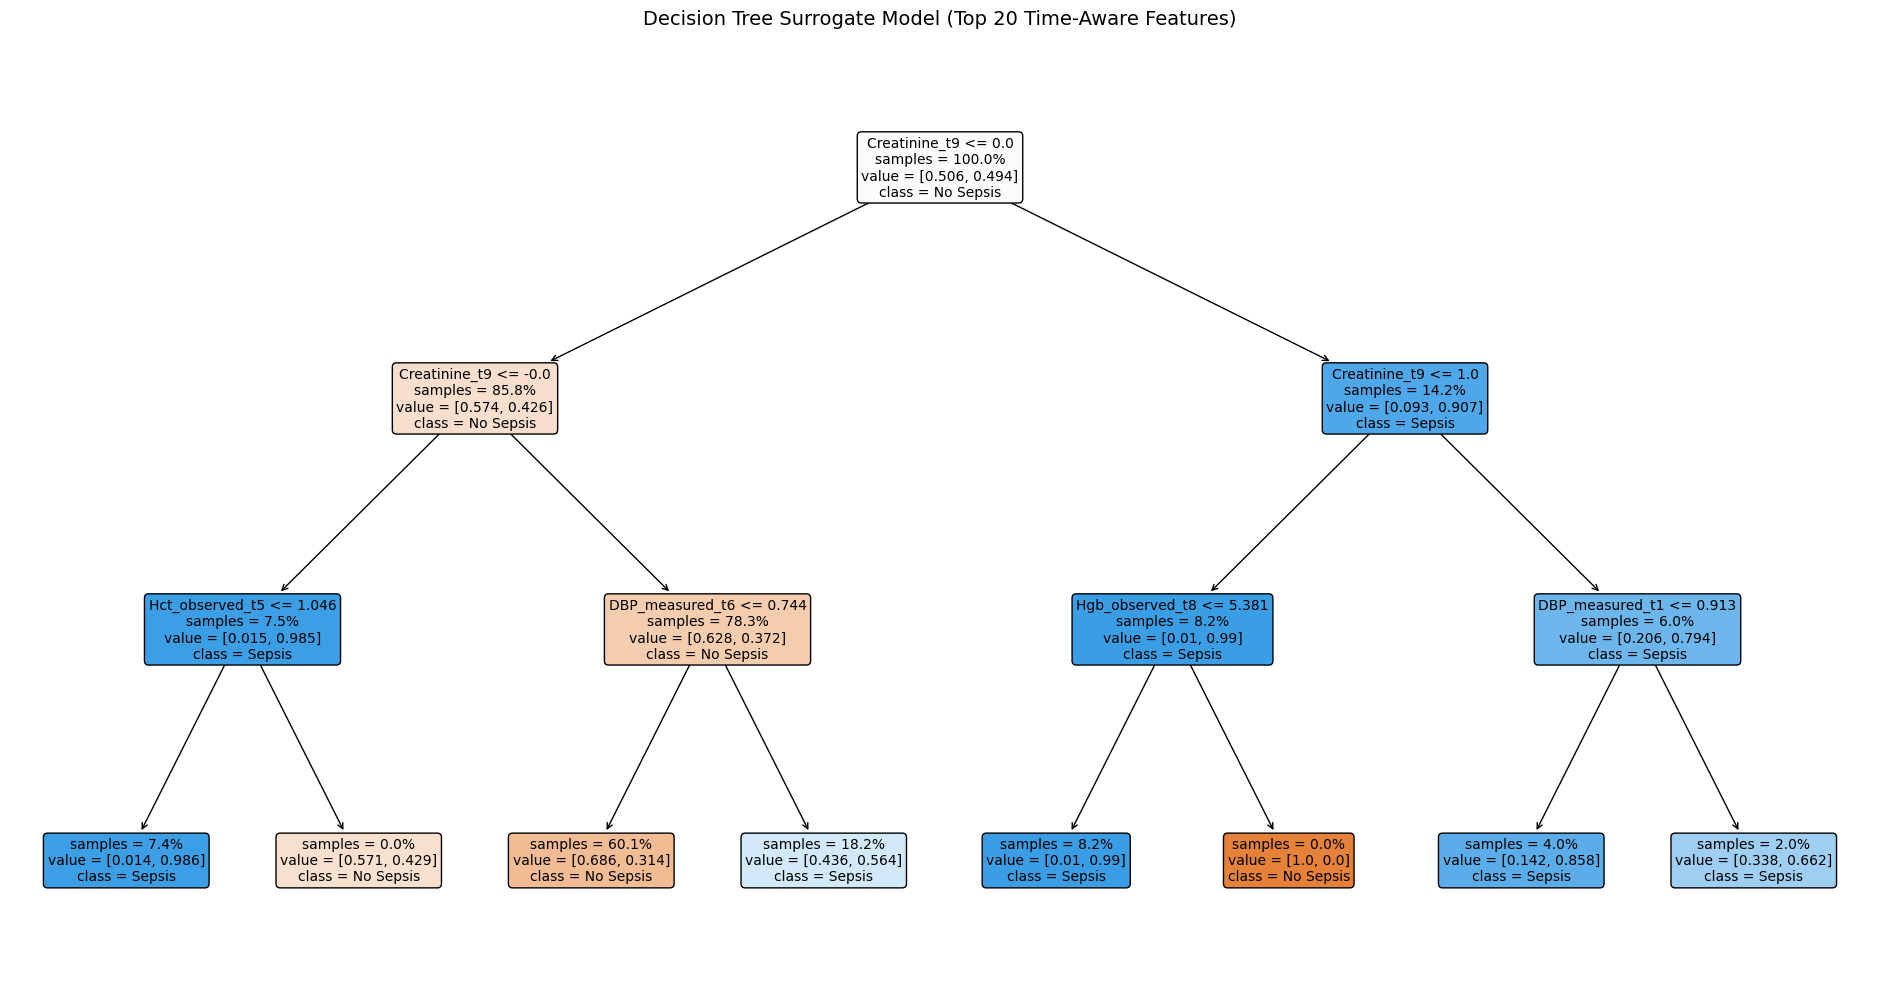

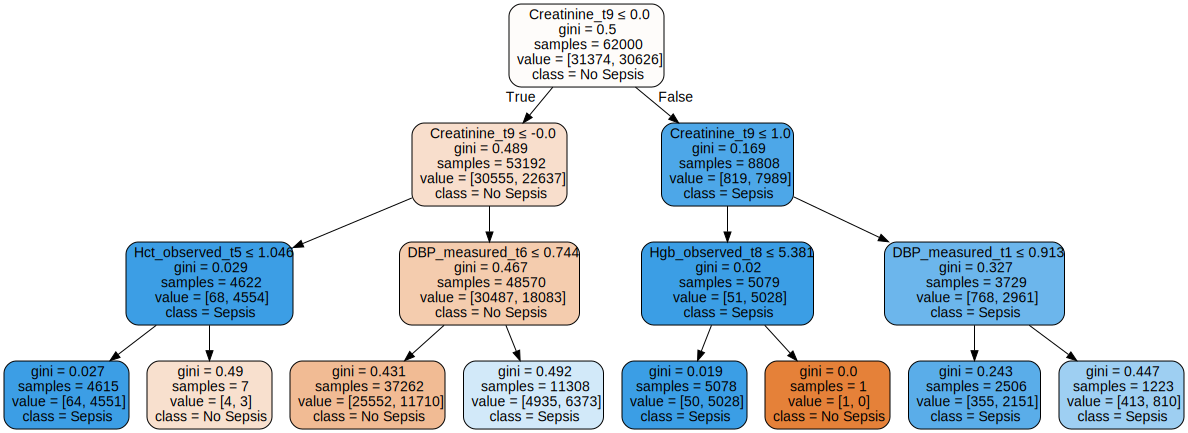

In [ ]:
feature_names = [f"{feat}_t{timestep}"
                 for timestep in range(X_train.shape[1])
                 for feat in feature_cols]

full_feature_importance = surrogate_model.feature_importances_
top_features = np.argsort(full_feature_importance)[-20:]

top_feature_names = [feature_names[i] for i in top_features]

X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_train_top = X_train_flat[:, top_features]

from sklearn.tree import DecisionTreeClassifier, plot_tree
surrogate_top = DecisionTreeClassifier(max_depth=3, random_state=42)
surrogate_top.fit(X_train_top, train_predictions_class)

plt.figure(figsize=(24, 12))
plot_tree(surrogate_top,
          filled=True,
          feature_names=top_feature_names,
          class_names=["No Sepsis", "Sepsis"],
          rounded=True,
          proportion=True,
          fontsize=10,
          impurity=False)
plt.title("Decision Tree Surrogate Model (Top 20 Time-Aware Features)", pad=20, fontsize=14)
plt.show()

from sklearn.tree import export_graphviz
import graphviz

dot_data = export_graphviz(surrogate_top,
                          out_file=None,
                          feature_names=top_feature_names,
                          class_names=["No Sepsis", "Sepsis"],
                          filled=True,
                          rounded=True,
                          special_characters=True)

graph = graphviz.Source(dot_data)
graph.render("sepsis_surrogate_tree", format='png', cleanup=True)
display(graph)


### **Glopal Model Agnostic PFI**

In [ ]:
def compute_custom_pfi(model, X, y, metric_fn=roc_auc_score):
    baseline_pred = model.predict(X, verbose=0).ravel()
    baseline_score = metric_fn(y, baseline_pred)

    n_features = X.shape[2]
    importances = []

    for i in tqdm(range(n_features), desc="Permuting features"):
        X_permuted = X.copy()

        # Shuffle feature i across samples (but keep timestep structure)
        for t in range(X.shape[1]):
            np.random.shuffle(X_permuted[:, t, i])

        permuted_pred = model.predict(X_permuted, verbose=0).ravel()
        permuted_score = metric_fn(y, permuted_pred)

        # Importance is the drop in score
        importance = baseline_score - permuted_score
        importances.append(importance)

    return importances, baseline_score


In [ ]:
def compute_custom_pfi(model, X, y, metric_fn=roc_auc_score):
    print("\n[INFO] Computing baseline AUC...")
    baseline_pred = model.predict(X, verbose=0).ravel()
    baseline_score = metric_fn(y, baseline_pred)
    print(f"[INFO] Baseline AUC = {baseline_score:.4f}")

    n_features = X.shape[2]
    importances = []

    print("[INFO] Permuting each feature across all timesteps...")
    for i in tqdm(range(n_features), desc="Permuting features"):
        X_permuted = X.copy()

        # Shuffle feature i across all samples, for each timestep
        for t in range(X.shape[1]):
            np.random.shuffle(X_permuted[:, t, i])

        permuted_pred = model.predict(X_permuted, verbose=0).ravel()
        permuted_score = metric_fn(y, permuted_pred)
        importances.append(baseline_score - permuted_score)

    return importances, baseline_score


pfi_scores, baseline_auc = compute_custom_pfi(model, X_test, y_test)

true_feature_cols = feature_cols

if len(true_feature_cols) != len(pfi_scores):
    print("[WARNING] Feature name and importance length mismatch! Fixing by truncation...")
    min_len = min(len(true_feature_cols), len(pfi_scores))
    true_feature_cols = true_feature_cols[:min_len]
    pfi_scores = pfi_scores[:min_len]


pfi_df = pd.DataFrame({
    "Feature": true_feature_cols,
    "Importance": pfi_scores
}).sort_values("Importance", ascending=False)
pfi_scores, baseline_auc = compute_custom_pfi(model, X_test, y_test)
true_feature_cols = feature_cols

if len(true_feature_cols) != len(pfi_scores):
    print("[WARNING] Feature name and importance length mismatch! Fixing by truncation...")
    min_len = min(len(true_feature_cols), len(pfi_scores))
    true_feature_cols = true_feature_cols[:min_len]
    pfi_scores = pfi_scores[:min_len]

pfi_df = pd.DataFrame({
    "Feature": true_feature_cols,
    "Importance": pfi_scores
}).sort_values("Importance", ascending=False)




[INFO] Computing baseline AUC...
[INFO] Baseline AUC = 0.9288
[INFO] Permuting each feature across all timesteps...


Permuting features: 100%|██████████| 51/51 [01:09<00:00,  1.37s/it]


[WARNING] Feature name and importance length mismatch! Fixing by truncation...

[INFO] Computing baseline AUC...
[INFO] Baseline AUC = 0.9288
[INFO] Permuting each feature across all timesteps...


Permuting features: 100%|██████████| 51/51 [01:10<00:00,  1.38s/it]

[WARNING] Feature name and importance length mismatch! Fixing by truncation...


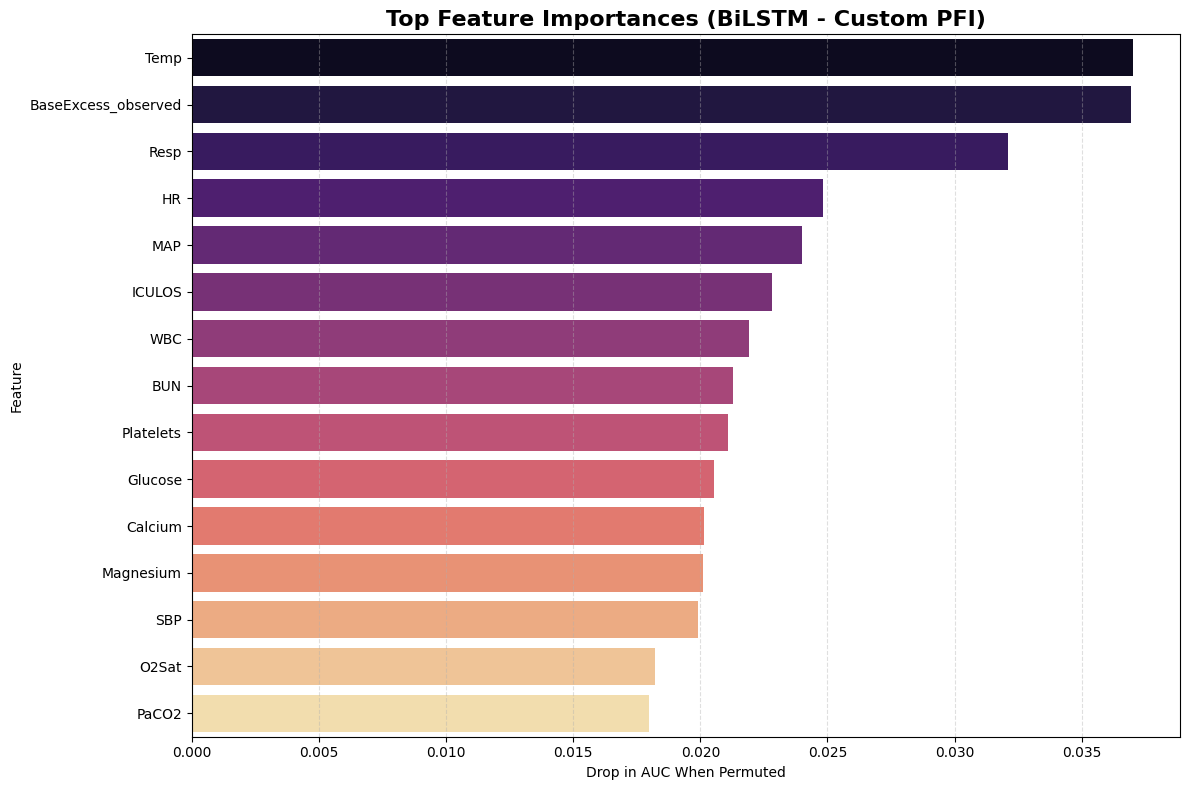

In [ ]:
top_n = 15
plt.figure(figsize=(12, 8))
sns.barplot(x="Importance", y="Feature", data=pfi_df.head(top_n), palette='magma')
plt.title("Top Feature Importances (BiLSTM - Custom PFI)", fontsize=16, weight='bold')
plt.xlabel("Drop in AUC When Permuted")
plt.ylabel("Feature")
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


In [ ]:
def get_top_features(model, X, y, feature_names, n_features=10):
    print("Calculating feature importances...")


    baseline_score = accuracy_score(y, model.predict(X).round())

    feature_importances = np.zeros(X.shape[2])

    for feat_idx in tqdm(range(X.shape[2])):
        X_permuted = X.copy()
        # Permute the feature across all timesteps
        for t in range(X.shape[1]):
            X_permuted[:, t, feat_idx] = np.random.permutation(X_permuted[:, t, feat_idx])

        permuted_score = accuracy_score(y, model.predict(X_permuted).round())
        feature_importances[feat_idx] = baseline_score - permuted_score

    sorted_idx = np.argsort(feature_importances)[::-1]
    top_indices = sorted_idx[:n_features]
    top_features = [(feature_names[i], feature_importances[i])
                   for i in top_indices]

    print("\nTop 10 Important Features:")
    for i, (feat, imp) in enumerate(top_features, 1):
        print(f"{i}. {feat}: {imp:.4f}")

    return top_indices, feature_importances

In [ ]:
# Cell 3: Execute feature importance calculation
print("Starting feature importance calculation...")
top_indices, feature_importances = get_top_features(
    model=model,
    X=X_test,
    y=y_test,
    feature_names=feature_cols,
    n_features=10
)

Starting feature importance calculation...
Calculating feature importances...
719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


  0%|          | 0/51 [00:00<?, ?it/s]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


  2%|▏         | 1/51 [00:01<01:09,  1.38s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


  4%|▍         | 2/51 [00:02<01:07,  1.37s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


  6%|▌         | 3/51 [00:04<01:06,  1.38s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


  8%|▊         | 4/51 [00:05<01:04,  1.38s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 10%|▉         | 5/51 [00:06<01:03,  1.37s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 12%|█▏        | 6/51 [00:08<01:01,  1.37s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 14%|█▎        | 7/51 [00:09<01:00,  1.37s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 16%|█▌        | 8/51 [00:11<00:59,  1.38s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 18%|█▊        | 9/51 [00:12<00:58,  1.40s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 20%|█▉        | 10/51 [00:13<00:58,  1.42s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 22%|██▏       | 11/51 [00:15<00:56,  1.42s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 24%|██▎       | 12/51 [00:16<00:54,  1.40s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 25%|██▌       | 13/51 [00:18<00:52,  1.39s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 27%|██▋       | 14/51 [00:19<00:51,  1.38s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 29%|██▉       | 15/51 [00:20<00:49,  1.38s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 31%|███▏      | 16/51 [00:22<00:48,  1.38s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 33%|███▎      | 17/51 [00:23<00:46,  1.38s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 35%|███▌      | 18/51 [00:24<00:45,  1.39s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 37%|███▋      | 19/51 [00:26<00:43,  1.37s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 39%|███▉      | 20/51 [00:27<00:42,  1.36s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 41%|████      | 21/51 [00:29<00:40,  1.36s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 43%|████▎     | 22/51 [00:30<00:39,  1.35s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 45%|████▌     | 23/51 [00:31<00:38,  1.36s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 47%|████▋     | 24/51 [00:33<00:36,  1.36s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 49%|████▉     | 25/51 [00:34<00:35,  1.36s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 51%|█████     | 26/51 [00:35<00:34,  1.38s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 53%|█████▎    | 27/51 [00:37<00:33,  1.38s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 55%|█████▍    | 28/51 [00:38<00:31,  1.37s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 57%|█████▋    | 29/51 [00:39<00:30,  1.38s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 59%|█████▉    | 30/51 [00:41<00:28,  1.37s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 61%|██████    | 31/51 [00:42<00:27,  1.38s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 63%|██████▎   | 32/51 [00:44<00:26,  1.40s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 65%|██████▍   | 33/51 [00:45<00:25,  1.41s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 67%|██████▋   | 34/51 [00:46<00:23,  1.40s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 69%|██████▊   | 35/51 [00:48<00:22,  1.39s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 71%|███████   | 36/51 [00:49<00:20,  1.38s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 73%|███████▎  | 37/51 [00:51<00:19,  1.38s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 75%|███████▍  | 38/51 [00:52<00:17,  1.38s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 76%|███████▋  | 39/51 [00:53<00:16,  1.38s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 78%|███████▊  | 40/51 [00:55<00:15,  1.38s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 80%|████████  | 41/51 [00:56<00:13,  1.38s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 82%|████████▏ | 42/51 [00:58<00:12,  1.38s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 84%|████████▍ | 43/51 [00:59<00:11,  1.38s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 86%|████████▋ | 44/51 [01:00<00:09,  1.38s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 88%|████████▊ | 45/51 [01:02<00:08,  1.38s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 90%|█████████ | 46/51 [01:03<00:06,  1.38s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 92%|█████████▏| 47/51 [01:04<00:05,  1.38s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 94%|█████████▍| 48/51 [01:06<00:04,  1.38s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 96%|█████████▌| 49/51 [01:07<00:02,  1.37s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 98%|█████████▊| 50/51 [01:09<00:01,  1.37s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


100%|██████████| 51/51 [01:10<00:00,  1.38s/it]


Top 10 Important Features:
1. BaseExcess_observed: 0.0410
2. Temp: 0.0360
3. MAP: 0.0282
4. ICULOS: 0.0268
5. Platelets: 0.0226
6. WBC: 0.0222
7. BUN: 0.0210
8. Resp: 0.0197
9. SBP: 0.0184
10. PaCO2: 0.0183


### **ALE**

In [ ]:
def compute_ale(model, X, feature_idx, n_bins=20, n_samples=500):
    """Compute ALE values for a specific feature across all timesteps"""
    if len(X) > n_samples:
        sample_indices = np.random.choice(len(X), n_samples, replace=False)
        X_sample = X[sample_indices]
    else:
        X_sample = X

    n_timesteps = X.shape[1]
    ale_values_per_timestep = []
    bin_centers_per_timestep = []

    for t in range(n_timesteps):
        feature_values = X_sample[:, t, feature_idx]
        percentiles = np.linspace(0, 100, n_bins + 1)
        bin_edges = np.percentile(feature_values, percentiles)
        bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

        ale = np.zeros(len(bin_edges) - 1)
        local_effects = []

        for i in range(len(bin_edges) - 1):
            lower, upper = bin_edges[i], bin_edges[i + 1]

            X_lower = X_sample.copy()
            X_upper = X_sample.copy()
            X_lower[:, t, feature_idx] = lower
            X_upper[:, t, feature_idx] = upper

            pred_lower = model.predict(X_lower, verbose=0).flatten()
            pred_upper = model.predict(X_upper, verbose=0).flatten()

            local_diff = pred_upper - pred_lower
            local_effects.append(local_diff)

        ale = np.mean(np.array(local_effects), axis=1)
        ale = np.cumsum(ale) - np.mean(ale)

        ale_values_per_timestep.append(ale)
        bin_centers_per_timestep.append(bin_centers)

    return bin_centers_per_timestep, ale_values_per_timestep

In [ ]:
def plot_ale_comparison(model, X_class0, X_class1, feature_names, feature_idx,
                       feature_name, n_bins=15, n_samples=500):
    """Plot side-by-side ALE comparison for a feature"""
    print(f"Computing ALE plots for feature: {feature_name}...")

    bins0, ale0 = compute_ale(model, X_class0, feature_idx, n_bins, n_samples)
    bins1, ale1 = compute_ale(model, X_class1, feature_idx, n_bins, n_samples)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
    fig.suptitle(f'ALE Analysis for {feature_name}', fontsize=16, y=1.05)

    for t in range(len(ale0)):
        ax1.plot(bins0[t], ale0[t], label=f'Timestep {t+1}', alpha=0.7)
    ax1.set_title('Effect on Non-Sepsis Predictions', fontsize=14)
    ax1.set_xlabel(f'Feature Value', fontsize=12)
    ax1.set_ylabel('Effect on Model Output', fontsize=12)
    ax1.axhline(0, color='gray', linestyle='--', linewidth=0.5)
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    # Plot for class 1 (Sepsis)
    for t in range(len(ale1)):
        ax2.plot(bins1[t], ale1[t], label=f'Timestep {t+1}', alpha=0.7)
    ax2.set_title('Effect on Sepsis Predictions', fontsize=14)
    ax2.set_xlabel(f'Feature Value', fontsize=12)
    ax2.set_ylabel('Effect on Model Output', fontsize=12)
    ax2.axhline(0, color='gray', linestyle='--', linewidth=0.5)
    ax2.grid(True, alpha=0.3)
    ax2.legend()

    plt.tight_layout()
    plt.show()

    print("ALE plot generation completed!")

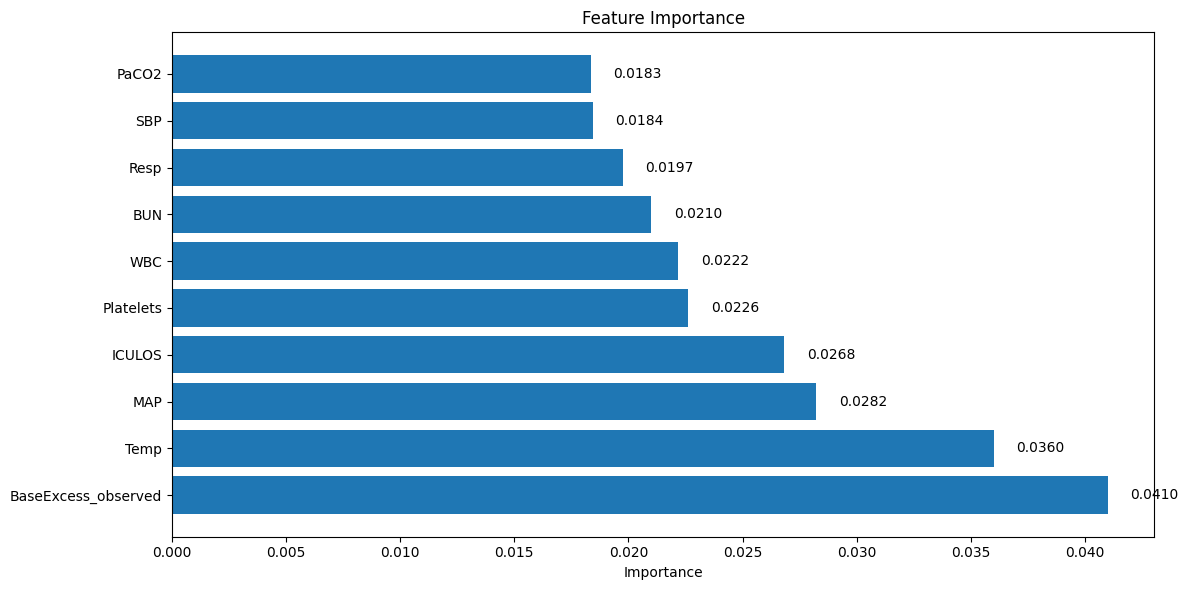

In [ ]:
def plot_feature_importance(feature_names, importances, top_indices):
    """Plot feature importance for top features"""
    top_features = [feature_names[i] for i in top_indices]
    top_importances = [importances[i] for i in top_indices]

    plt.figure(figsize=(12, 6))
    bars = plt.barh(range(len(top_features)), top_importances, align='center')
    plt.yticks(range(len(top_features)), top_features)
    plt.xlabel('Importance')
    plt.title('Feature Importance')

    # Add value labels on bars
    for i, v in enumerate(top_importances):
        plt.text(v + 0.001, i, f"{v:.4f}", va='center')

    plt.tight_layout()
    plt.show()

# Cell 7: Execute feature importance visualization
plot_feature_importance(feature_cols, feature_importances, top_indices)

In [ ]:
def create_interactive_ale_analysis(model, X_test, y_test, feature_cols, top_indices):
    X_class0 = X_test[y_test == 0]
    X_class1 = X_test[y_test == 1]


    feature_options = [(f"{i+1}. {feature_cols[idx]} ({feature_importances[idx]:.4f})")
                      for i, idx in enumerate(top_indices)]

    feature_dropdown = widgets.Dropdown(
        options=feature_options,
        value=feature_options[0],
        description='Select Feature:',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='50%')
    )

    # Create sliders for bins and sample size
    bins_slider = widgets.IntSlider(
        value=15,
        min=5,
        max=30,
        step=5,
        description='Number of Bins:',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='40%')
    )

    samples_slider = widgets.IntSlider(
        value=500,
        min=100,
        max=1000,
        step=100,
        description='Sample Size:',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='40%')
    )

    out = widgets.Output()

    def update_visualization(change):
        with out:
            clear_output(wait=True)

            selected_idx = int(feature_dropdown.value.split('.')[0]) - 1
            feature_idx = top_indices[selected_idx]
            feature_name = feature_cols[feature_idx]

            # Generate ALE plots
            plot_ale_comparison(
                model=model,
                X_class0=X_class0,
                X_class1=X_class1,
                feature_names=feature_cols,
                feature_idx=feature_idx,
                feature_name=feature_name,
                n_bins=bins_slider.value,
                n_samples=samples_slider.value
            )

    run_button = widgets.Button(
        description='Generate ALE Plots',
        button_style='primary',
        tooltip='Click to generate ALE plots for selected feature',
        layout=widgets.Layout(width='30%')
    )

    run_button.on_click(update_visualization)

    # Display widgets
    display(widgets.VBox([
        widgets.HBox([feature_dropdown]),
        widgets.HBox([bins_slider, samples_slider]),
        run_button,
        out
    ]))

In [ ]:
print("Launching interactive feature analysis tool...")
create_interactive_ale_analysis(
    model=model,
    X_test=X_test,
    y_test=y_test,
    feature_cols=feature_cols,
    top_indices=top_indices
)
print("Click 'Generate ALE Plots' to visualize feature effects")

Launching interactive feature analysis tool...


Click 'Generate ALE Plots' to visualize feature effects


Note: you may need to restart the kernel to use updated packages.


719/719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Analyzing 10 high-risk samples...


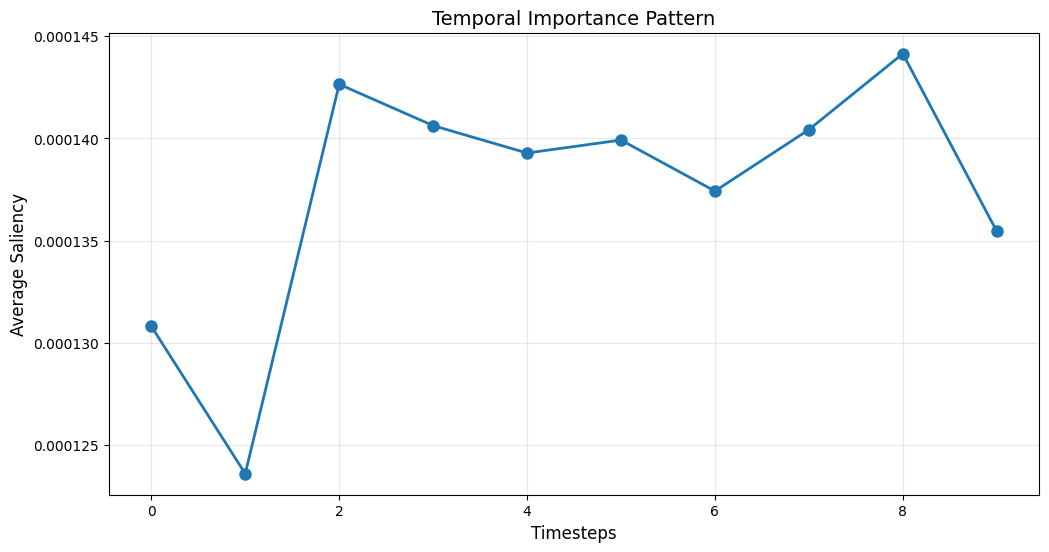

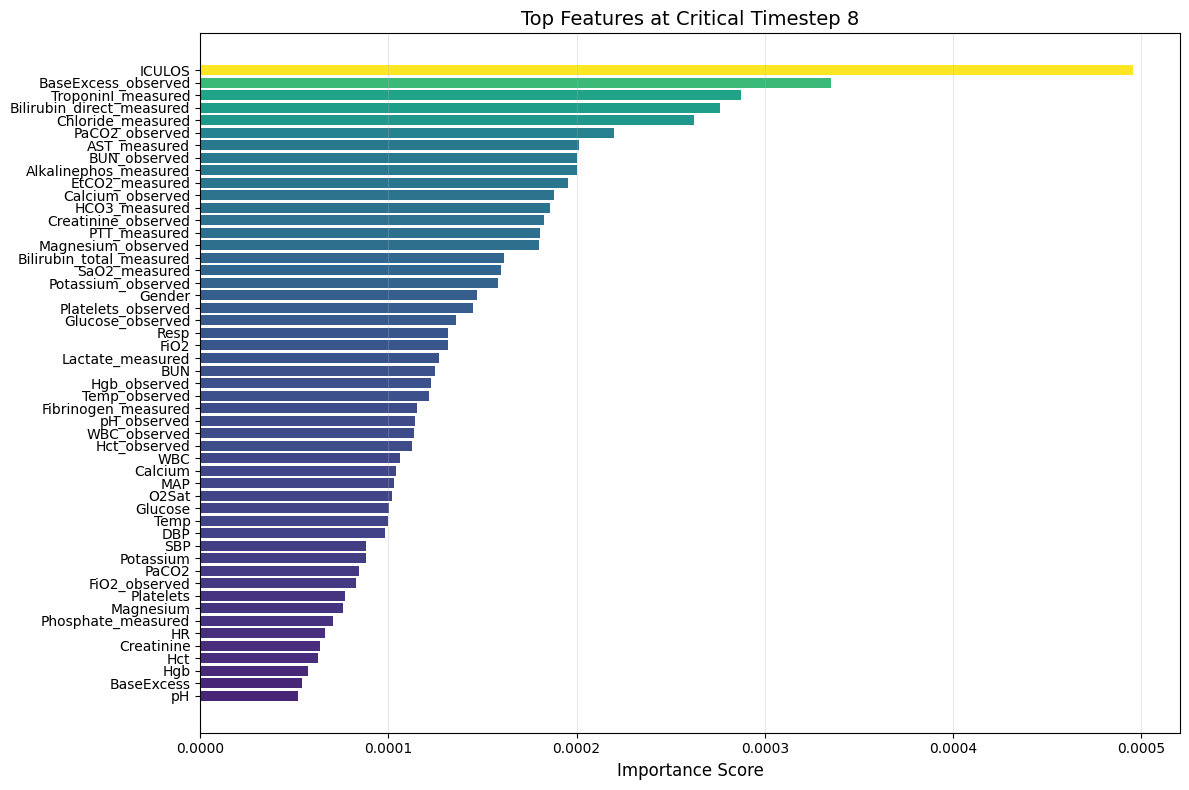

In [ ]:
def Critical_time_steps(model, X_sample, feature_cols):

    if tf.is_tensor(X_sample):
        X_sample = X_sample.numpy()

    if len(X_sample.shape) == 2:
        X_sample = np.expand_dims(X_sample, axis=0)

    X_sample_tensor = tf.convert_to_tensor(X_sample, dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(X_sample_tensor)
        predictions = model(X_sample_tensor)
    grads = tape.gradient(predictions, X_sample_tensor)

    grads = grads.numpy()

    saliency = np.mean(np.abs(grads), axis=(0,2))  # Mean across samples and features

    plt.figure(figsize=(12, 6))
    plt.plot(saliency, 'o-', linewidth=2, markersize=8)
    plt.xlabel('Timesteps', fontsize=12)
    plt.ylabel('Average Saliency', fontsize=12)
    plt.title('Temporal Importance Pattern', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.show()

    critical_timestep = np.argmax(saliency)
    feature_importance = np.mean(np.abs(grads[:, critical_timestep, :]), axis=0)

    sorted_idx = np.argsort(feature_importance)

    plt.figure(figsize=(12, 8))
    colors = plt.cm.viridis(feature_importance[sorted_idx]/np.max(feature_importance))
    plt.barh(np.array(feature_cols)[sorted_idx],
             feature_importance[sorted_idx],
             color=colors)
    plt.title(f'Top Features at Critical Timestep {critical_timestep}', fontsize=14)
    plt.xlabel('Importance Score', fontsize=12)
    plt.grid(True, axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

y_pred = model.predict(X_test).flatten()
high_risk_idx = np.argsort(y_pred)[-10:]
high_risk_samples = X_test[high_risk_idx]

print(f"Analyzing {len(high_risk_samples)} high-risk samples...")
Critical_time_steps(model, high_risk_samples, feature_cols)

Analyzing 5 samples using gradients
Gradient shape: (5, 10, 51)


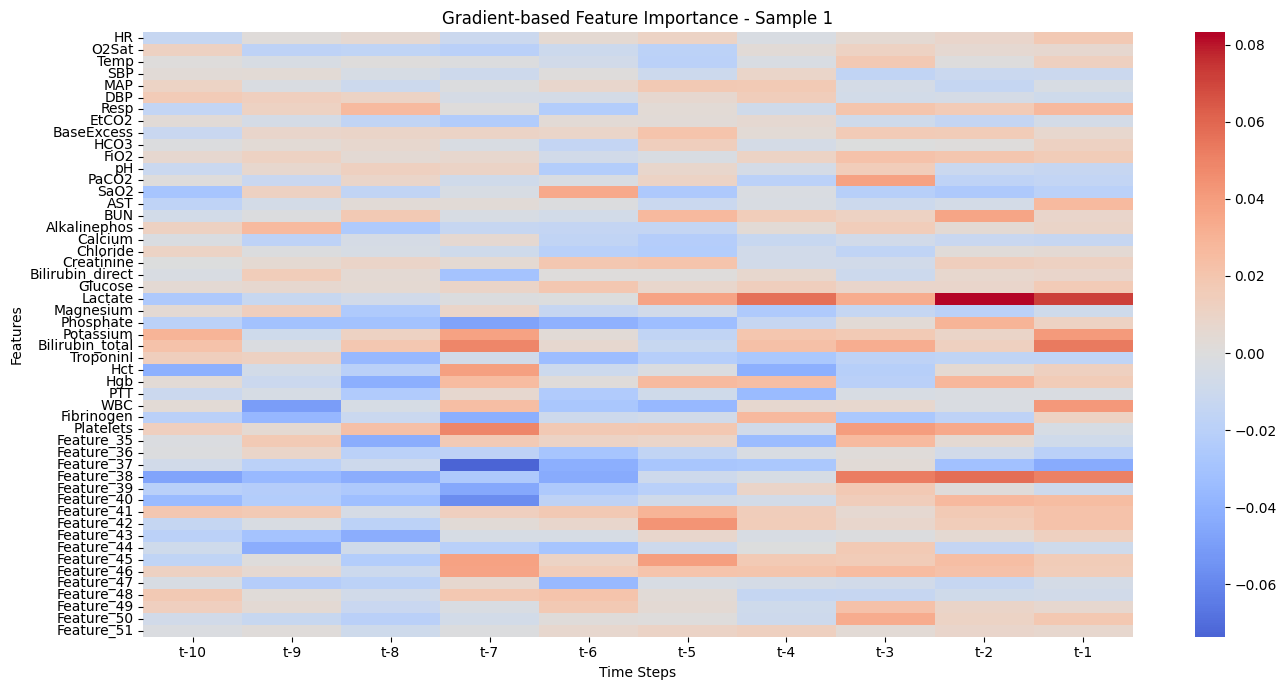

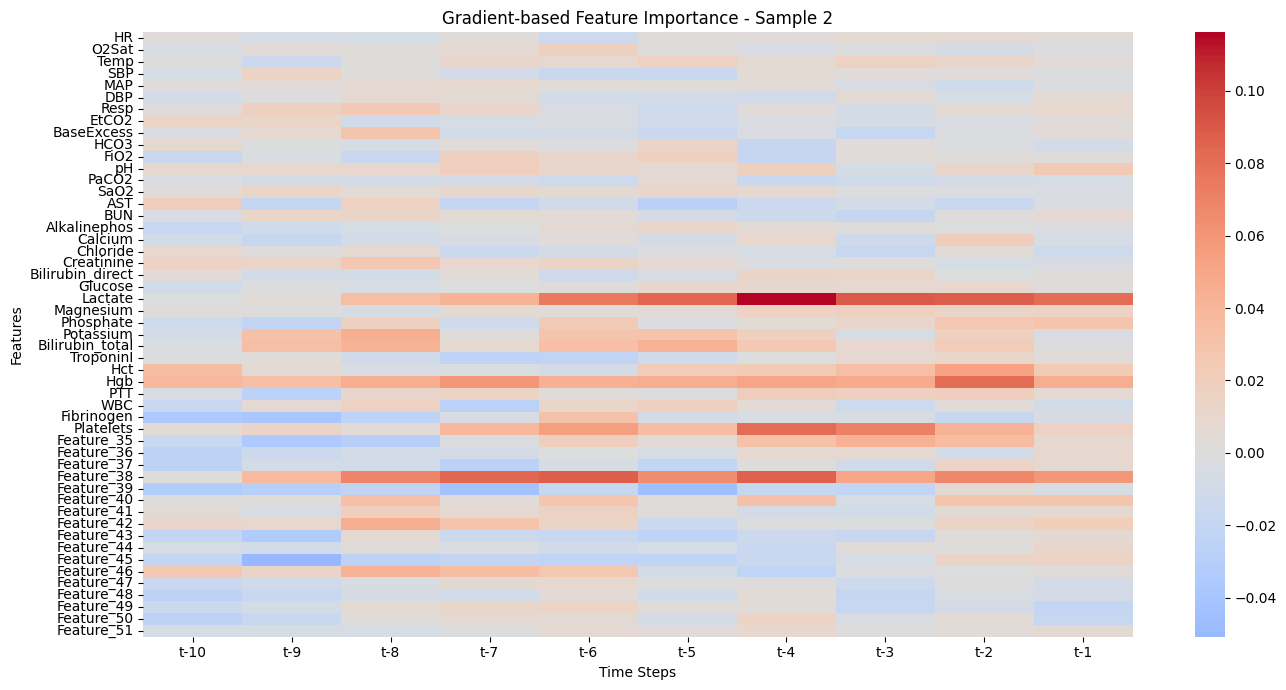

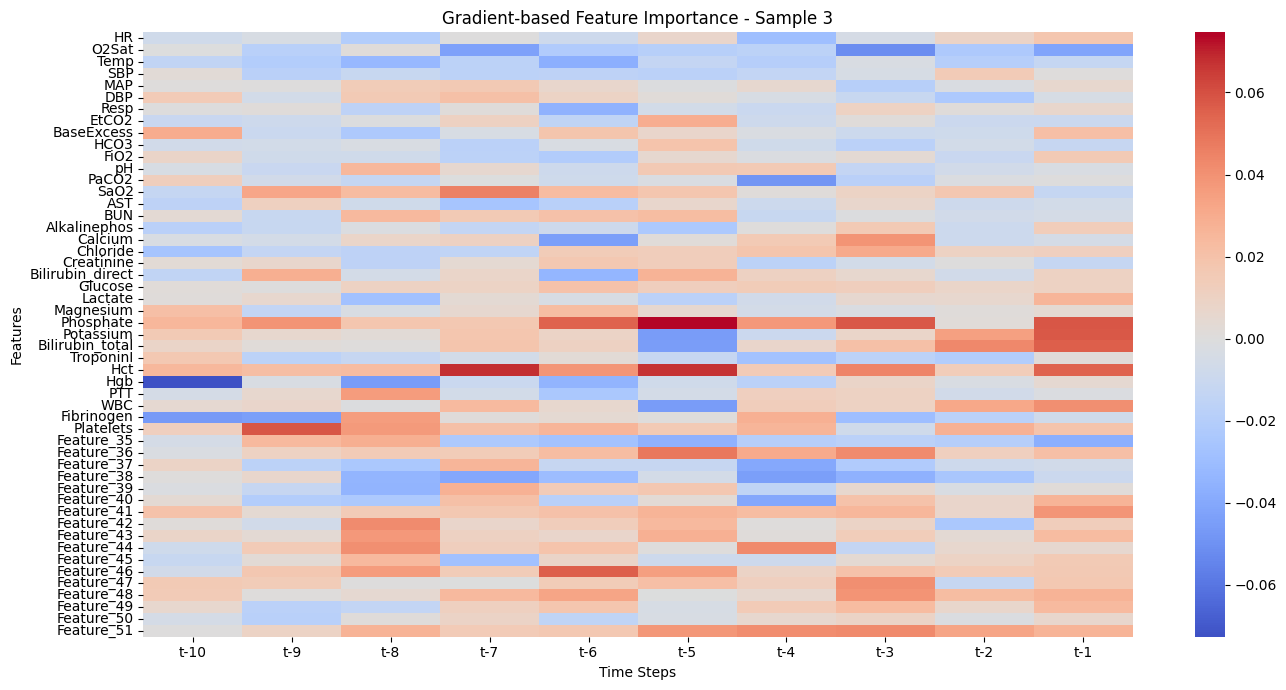

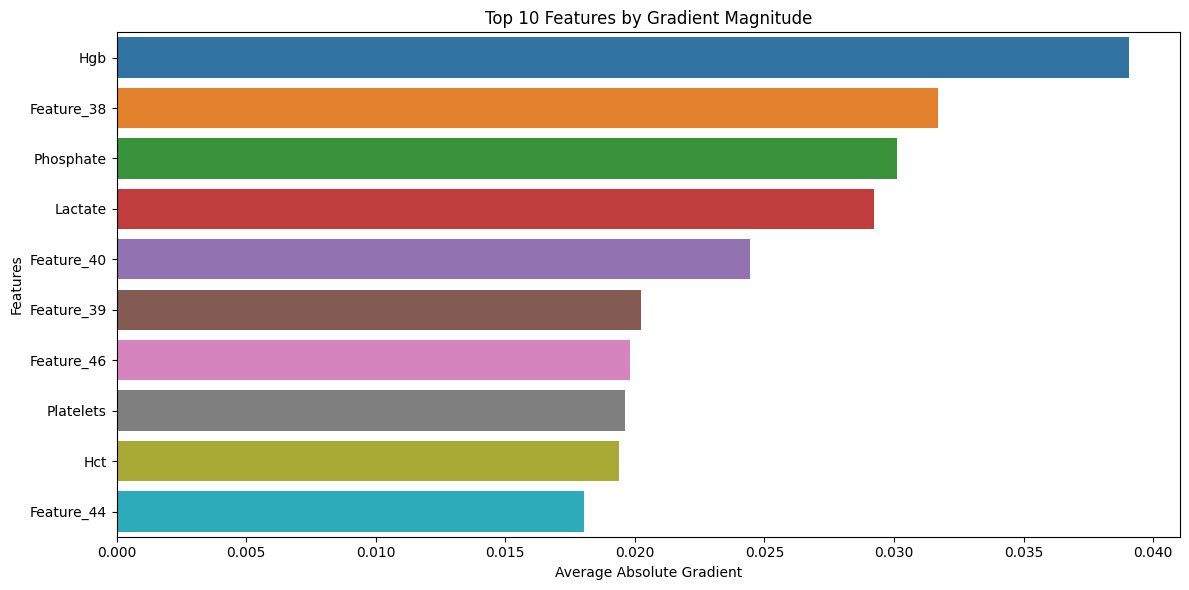

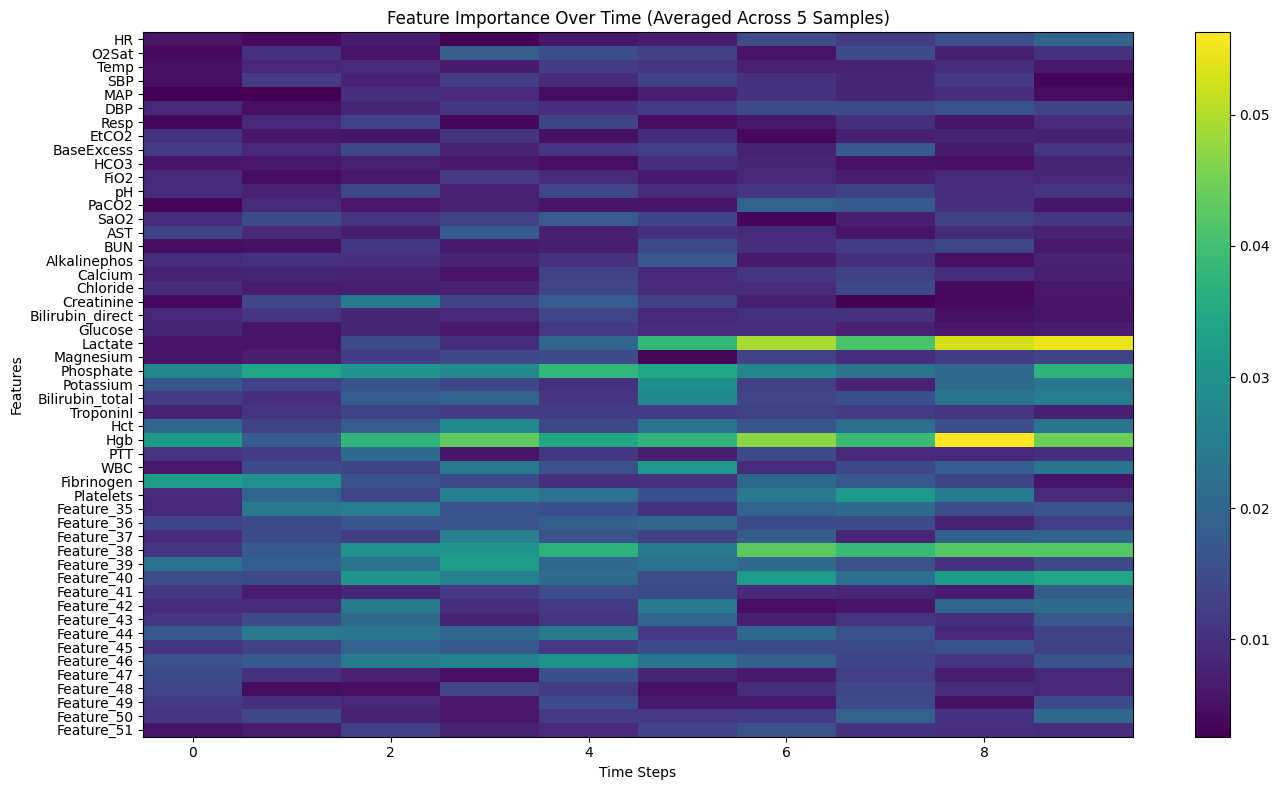

In [ ]:
def get_feature_names(num_features):
    base_features = [
        'HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
        'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
        'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
        'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium', 'Bilirubin_total',
        'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC', 'Fibrinogen', 'Platelets',

    ]

    if num_features > len(base_features):
        for i in range(len(base_features), num_features):
            base_features.append(f"Feature_{i+1}")

    return base_features[:num_features]

def check_compatibility(model, data):
    model_shape = model.input_shape[1:]
    data_shape = data.shape[1:]

    if model_shape != data_shape:
        print(f"WARNING: Data shape {data_shape} doesn't match model input shape {model_shape}")
        return False
    return True

def select_samples(X, num_samples=10):
    if len(X) > num_samples:
        sample_indices = np.random.choice(len(X), num_samples, replace=False)
        samples = X[sample_indices]
    else:
        samples = X
    return samples

def interpret_with_gradients(model, X, feature_names=None, num_samples=5, class_idx=1):

    if not check_compatibility(model, X):
        print("Error: Model and data dimensions don't match!")
        return None

    # Generate feature names if not provided
    if feature_names is None:
        feature_names = get_feature_names(X.shape[2])

    samples = select_samples(X, num_samples)
    print(f"Analyzing {len(samples)} samples using gradients")

    X_tensor = tf.convert_to_tensor(samples, dtype=tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(X_tensor)
        predictions = model(X_tensor)
        if class_idx == 1:
            target = predictions  # For positive class
        else:
            target = 1 - predictions  # For negative class

    gradients = tape.gradient(target, X_tensor).numpy()
    print(f"Gradient shape: {gradients.shape}")

    n_timesteps = gradients.shape[1]

    for i in range(min(3, len(samples))):
        plt.figure(figsize=(14, 7))
        sns.heatmap(gradients[i].T, cmap='coolwarm', center=0,
                  xticklabels=[f"t-{n_timesteps-t}" for t in range(n_timesteps)],
                  yticklabels=feature_names)
        plt.title(f"Gradient-based Feature Importance - Sample {i+1}")
        plt.xlabel("Time Steps")
        plt.ylabel("Features")
        plt.tight_layout()
        plt.show()

    avg_importance = np.mean(np.abs(gradients), axis=0)
    avg_feature_importance = np.mean(avg_importance, axis=0)
    top_indices = np.argsort(avg_feature_importance)[::-1][:10]

    plt.figure(figsize=(12, 6))
    sns.barplot(x=avg_feature_importance[top_indices],
              y=[feature_names[j] for j in top_indices])
    plt.title("Top 10 Features by Gradient Magnitude")
    plt.xlabel("Average Absolute Gradient")
    plt.ylabel("Features")
    plt.tight_layout()
    plt.show()

    # 4. Show temporal heatmap
    plt.figure(figsize=(14, 8))
    im = plt.imshow(avg_importance.T, aspect='auto', cmap='viridis')
    plt.title(f"Feature Importance Over Time (Averaged Across {len(samples)} Samples)")
    plt.xlabel("Time Steps")
    plt.ylabel("Features")
    plt.yticks(range(len(feature_names)), feature_names)
    plt.colorbar(im)
    plt.tight_layout()
    plt.show()

    return avg_feature_importance



gradient_importance = interpret_with_gradients(
    model=model,
    X=X_test,

    num_samples=5
)

In [ ]:
print(df.columns[37])


Fibrinogen_measured
